In [1]:
import torch
from torch import nn
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from image_helper import ImageHelper

/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SRCNN(nn.Module):
    def __init__(self) -> None:
        super(SRCNN, self).__init__()
        # 4.3 Model and Performance Trade-offs
        # Based on the basic network settings (i.e., f1 = 9, f2 = 1, f3 = 5, n1 = 64, and n2 = 32),
        f1 = 9
        f2 = 1
        f3 = 5
        n1 = 64
        n2 = 32

        self.model = nn.Sequential(

            # 3.1.1 Patch extraction and representation
            nn.Conv2d(in_channels=3, out_channels=n1,
                      kernel_size=(f1, f1), padding=(f1-1)//2),
            nn.ReLU(),

            # 3.1.2 Non-linear mapping
            nn.Conv2d(in_channels=n1, out_channels=n2,
                      kernel_size=(f2, f2), padding=(f2-1)//2),
            nn.ReLU(),

            # 3.1.3 Reconstruction
            nn.Conv2d(in_channels=n2, out_channels=3,
                      kernel_size=(f3, f3), padding=(f3-1)//2),
        )

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


In [4]:
# Instancianting the model
model = SRCNN()

# hyperparameters
lr = 1e-5

In [5]:
transform_x = transforms.Compose([
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((33, 33), interpolation=Image.BICUBIC),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    # resize image to 256x256 and downsample by BICUBIC interpolation
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir="./datasets/DIV2K_train_HR/DIV2K_train_HR/", transform=transform_x, target_transform=transform_y)
test_data_set = CustomImageDataset(
    img_dir="./datasets/DIV2K_valid_HR/DIV2K_valid_HR/", transform=transform_x, target_transform=transform_y)

train_dataloader = DataLoader(train_data_set, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data_set, batch_size=16)


/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [6]:
# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


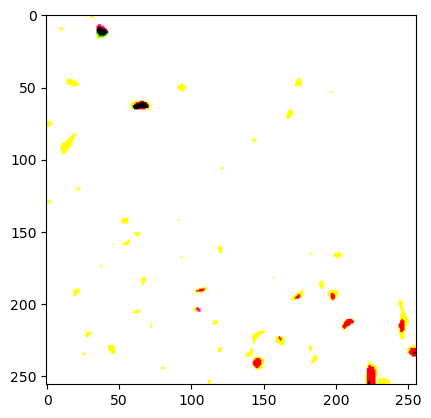

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


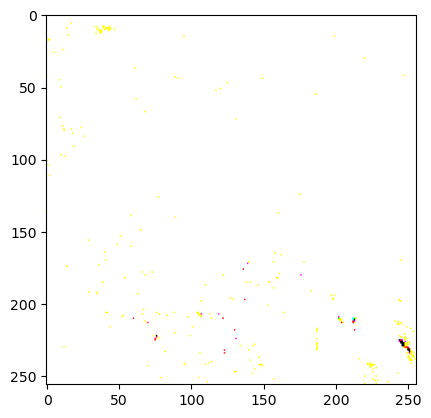

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


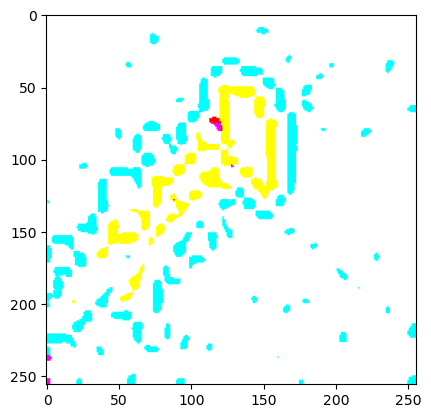

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


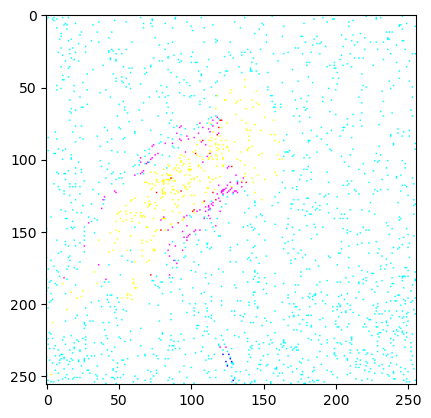

In [7]:
# example of training image
ImageHelperInstance = ImageHelper()

for a, b in train_data_set:
    ImageHelperInstance.show_tensor_as_image(a)
    ImageHelperInstance.show_tensor_as_image(b)
    break

for X, y in train_dataloader:
    ImageHelperInstance.show_tensor_as_image(X[0])
    ImageHelperInstance.show_tensor_as_image(y[0])
    break


In [8]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


KeyboardInterrupt: 